# OCO-2 XCO2 Data Analysis

In [52]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [53]:
import datetime
import matplotlib.pyplot as plt
# https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn')

import numpy as np
import os
import os.path
import pandas as pd

from IPython.core.display import HTML
from IPython.display import clear_output
from IPython.core.pylabtools import figsize

C:\Users\user\AppData\Local\Temp\ipykernel_14508\2827603304.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [54]:
from oco_tools import *

In [55]:
file_dict = dict_oco2_xco2
file_dict

{'lat': 'latitude',
 'lon': 'longitude',
 'sza': 'solar_zenith_angle',
 'vza': 'sensor_zenith_angle',
 'saa': 'Sounding/solar_azimuth_angle',
 'vaa': 'Sounding/sensor_azimuth_angle',
 'xco2': 'xco2',
 'xco2_sigma': 'xco2_uncertainty',
 'xco2_qual': 'xco2_quality_flag',
 'time': 'time'}

In [56]:
# which dataset
path_files = 'downloads/subset_OCO2_L2_Lite_FP_11.1r_20230920_091205_'
year='14'

## Select region

In [57]:
# NZ bounding box
latMin = -48
latMax = -34
lonMin = 165
lonMax = 179

In [43]:
oco2_aoi = OCO2(path_files+'/*'+year+'*.nc4', file_dict, latMin, latMax, lonMin, lonMax)

found 53 files
total num soundings in aoi  13115  total 7187985  % match 0.18245725331925428


In [58]:
t_unit_oco2    = "seconds since 1970-1-1 0:0:0"
t_cal = u"gregorian"

# Convert oco2 time units to a python time
oco2_aoi.time_python  = convert_time(oco2_aoi.time, t_unit_oco2, t_cal)
oco2_aoi.time_str = [datetime.datetime.fromisoformat(str(date)) for date in oco2_aoi.time_python]

In [68]:
# oco2_aoi.time[0] # seconds since 1970
# oco2_aoi.time_python[0].strftime("%d/%m/%Y, %H:%M:%S")
# oco2_aoi.time_str[0]

In [59]:
df = pd.DataFrame({"Latitude":oco2_aoi.lat,"Longitude":oco2_aoi.lon,f"CO2-20{year} (ppm)":oco2_aoi.xco2})
# df['CO2'] = oco2_aoi.xco2

In [60]:
df.to_csv(f"CO2-20{year}",index=False)

## Timeseries

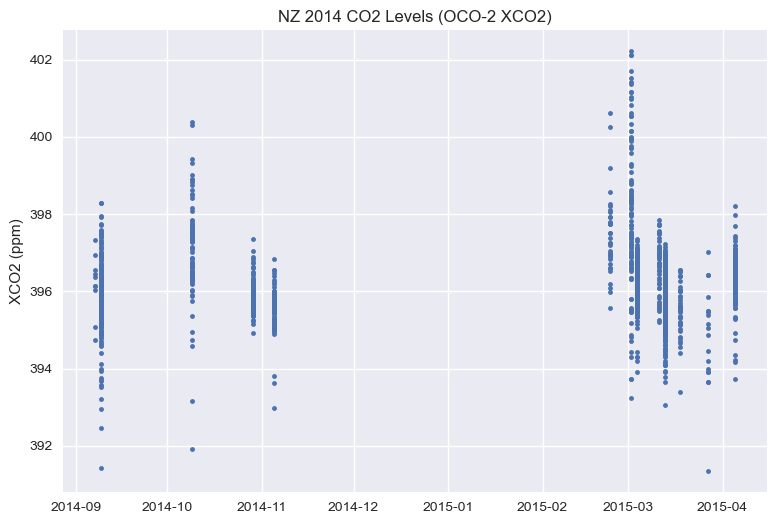

In [69]:
# plot a timeseries
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(oco2_aoi.time_str, oco2_aoi.xco2,'.')
plt.ylabel('XCO2 (ppm)')
plt.title('NZ 2014 CO2 Levels (OCO-2 XCO2)')
plt.savefig('image_results/oco2-xco2-nz-2014.png')

## Histogram

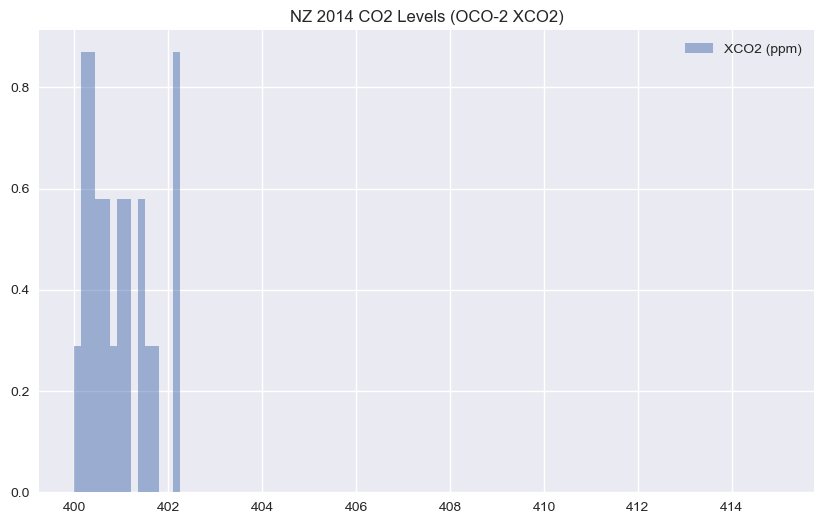

In [70]:
# let us look at a histogram
plt.figure(figsize=(10,6))
plt.hist(oco2_aoi.xco2, 100,range=(400,415), density=True, alpha=0.5, label='XCO2 (ppm)')
plt.title('NZ 2014 CO2 Levels (OCO-2 XCO2)')
plt.legend(loc=0)
plt.savefig('image_results/oco2-xco2-nz-2014-hist.png')

In [71]:
print('Standard deviation of measurement ' + str(np.std(oco2_aoi.xco2)) )
print('Expected standard deviation based on posteriori error ' + str(np.mean(oco2_aoi.xco2_sigma)) )

Standard deviation of measurement 0.754406
Expected standard deviation based on posteriori error 0.43941766


##  Running average timeseries

In [72]:
# Get data every 3 days and create a running mean of +/- 3 days:
# Define data range to smooth on (every 3 days)
from datetime import datetime
dates = np.arange('2014-01', '2015-12', dtype='datetime64[3D]').astype(datetime)

In [73]:
len(dates)

233

In [74]:
# Use dates with a 3 day time-step and now use a +/- 3 day filter for the running mean:
timeseries_oco2 = running_mean(oco2_aoi.time_str, oco2_aoi.xco2, dates, 3)

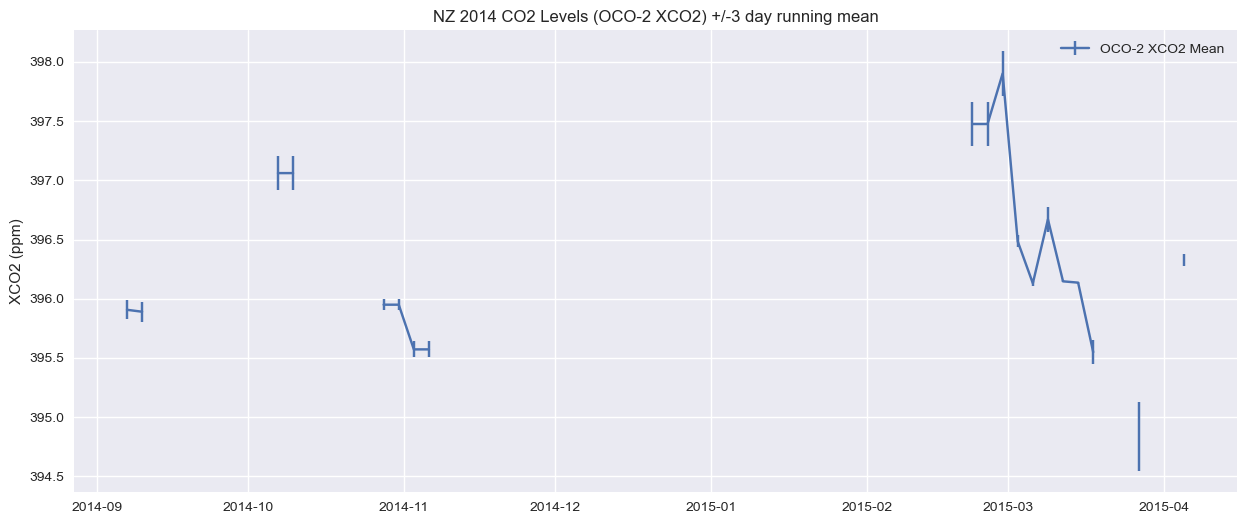

In [75]:
plt.figure(figsize=(15,6))
plt.errorbar(dates, timeseries_oco2.mean,yerr=timeseries_oco2.standard_error, label='OCO-2 XCO2 Mean')
plt.ylabel('XCO2 (ppm)')
plt.legend(loc=0)
plt.title('NZ 2014 CO2 Levels (OCO-2 XCO2) +/-3 day running mean')
plt.savefig('image_results/oco2-xco2-nz-2014-ravg.png')

# fin